The practice is performed following this tutorial: https://www.makeuseof.com/create-sentiment-analysis-model/, which used Trip Advisor Hotel Reviews dataset from Kaggle to build the sentiment analysis model

Dataset used to train the model in this practice: https://www.kaggle.com/datasets/kazanova/sentiment140/data, which is the dataset for ACM AI Tweetiment hackathon

In [15]:
! pip install tensorflow scikit-learn pandas numpy pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255313 sha256=ed069c789a1fb6151f1c0d75068019ba36262681dfbb733cc7a80f6f1524ad93
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import pickle5 as pickle


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [49]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment Analysis Dataset/tweetiment.csv", encoding = 'latin',header=None)

In [50]:
# Display the first few rows of the dataset
print(df.head())

   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  


In [51]:
# Select only the first and last columns
df = df[[5, 0]]
df.columns=['tweet', 'sentiment']
print(df.head())

                                               tweet  sentiment
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...          0
1  is upset that he can't update his Facebook by ...          0
2  @Kenichan I dived many times for the ball. Man...          0
3    my whole body feels itchy and like its on fire           0
4  @nationwideclass no, it's not behaving at all....          0


In [52]:
sentiment_distribution = df['sentiment'].value_counts()
print(sentiment_distribution)

sentiment
0    800000
4    800000
Name: count, dtype: int64


In [53]:
# changed label to 0 for negative and 1 for positive
df['sentiment'] = df['sentiment'].replace(4,1)
df = df.sample(frac=1).reset_index(drop=True)

In [55]:
# Check for missing values in the 'text' column
missing_values= df['tweet'].isnull().sum()
print("Number of missing values in 'tweet' column of training dataset:", missing_values)

# Drop rows with missing values
df = df.dropna(subset=['tweet'])

Number of missing values in 'tweet' column of training dataset: 0


In [56]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['tweet'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100, truncating='post')

In [57]:
# Convert sentiment labels to one-hot encoded vectors
sentiment_labels = pd.get_dummies(df['sentiment']).values

In [59]:
# Splitting the dataset into training and testing Sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, sentiment_labels, test_size=0.2)

## Creating and Training the Neural Network

In [65]:
# Creating the Neural Network
model = Sequential()
model.add(Embedding(5000, 100, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          500000    
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 global_max_pooling1d_3 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                      

In [66]:
# Stop training early if not improving
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [76]:
# Training the Neural Network
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/20
40000/40000 [==============================] - 1260s 31ms/step - loss: 0.3718 - accuracy: 0.8365 - val_loss: 0.3994 - val_accuracy: 0.8209
Epoch 2/20
40000/40000 [==============================] - 1207s 30ms/step - loss: 0.3585 - accuracy: 0.8430 - val_loss: 0.4163 - val_accuracy: 0.8187
Epoch 3/20
40000/40000 [==============================] - 1215s 30ms/step - loss: 0.3460 - accuracy: 0.8485 - val_loss: 0.4156 - val_accuracy: 0.8170
Epoch 4/20
40000/40000 [==============================] - 1205s 30ms/step - loss: 0.3339 - accuracy: 0.8540 - val_loss: 0.4234 - val_accuracy: 0.8146


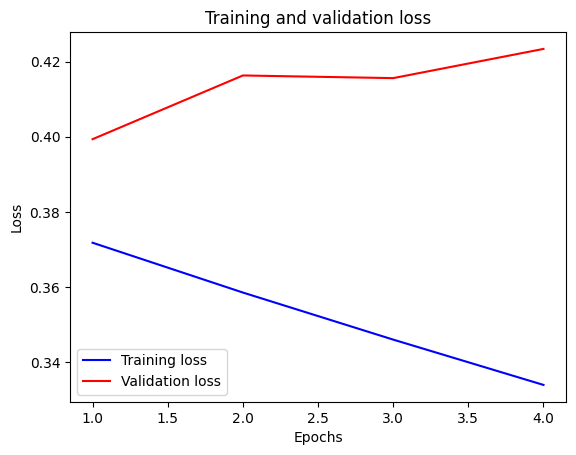

In [77]:
# Loss and accuracy values for training and validation sets
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Print or visualize the loss and accuracy curves
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the plot, the training loss decreases sharply while the validation loss slowly increases, it indicates that the model is fitting the training data too closely, capturing noise or irrelevant patterns that don't generalize well to new data. Early Stopping stop training when the validation loss starts to increase.

In [78]:
# Evaluating the Performance of the Trained Model
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
# Calculate accuracy score
# Calculate accuracy score
print("Accuracy:", accuracy_score(y_true, y_pred))
# Calculate F1-score
print("F1-score:", f1_score(y_true, y_pred, average='macro'))

10000/10000 [==============================] - 98s 10ms/step
Accuracy: 0.820946875
F1-score: 0.8209446776537175


In [79]:
# Saving the Model
model.save('my_tweetiment_analysis_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Using the Model to Classify the Sentiment of Given Text



In [80]:
# Load the saved model and tokenizer
import keras

model = keras.models.load_model('my_tweetiment_analysis_model.h5')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [81]:
# Define a function to predict the sentiment of input text
def predict_sentiment(text, model, tokenizer):
    # Tokenize and pad the input text
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence, maxlen=100)

    # Make a prediction using the trained model
    predicted_rating = model.predict(text_sequence)[0]

    # Map the predicted sentiment index to its corresponding label
    sentiment_mapping = {0: 'negative', 1: 'positive'}
    predicted_index = np.argmax(predicted_rating)
    predicted_sentiment_label = sentiment_mapping[predicted_index]

    return predicted_index, predicted_sentiment_label

In [82]:
positive_texts = [
    "I loved the new book. It's amazing!",
    "The weather today is beautiful.",
    "I'm feeling great today.",
    "I had a fantastic time at the party last night!",
    "I'm really excited about the upcoming event.",
    "The customer service was excellent!",
    "I feel so happy right now.",
    "The meeting went well.",
    "The hotel room was clean and comfortable.",
    "I'm proud of my achievements.",
    "I'm grateful for all the support I've received.",
    "Today was a productive day!",
    "I received some wonderful news today.",
    "The food at the restaurant was delicious.",
    "I'm surrounded by amazing friends and family.",
    "I'm making progress towards my goals.",
    "I'm enjoying every moment of life.",
    "I'm filled with optimism about the future.",
    "I'm thankful for the opportunities I've been given.",
    "I'm blessed to have such a fulfilling life."
]
print(len(positive_texts))

20


In [83]:
for text in positive_texts:
    predicted_index, predicted_sentiment = predict_sentiment(text, model, tokenizer)
    print("Text:", text)
    print("Predicted Sentiment Index:", predicted_index)
    print("Predicted Sentiment Label:", predicted_sentiment)
    print()

1/1 [==============================] - 0s 181ms/step
Text: I loved the new book. It's amazing!
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [==============================] - 0s 78ms/step
Text: The weather today is beautiful.
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [==============================] - 0s 87ms/step
Text: I'm feeling great today.
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [==============================] - 0s 59ms/step
Text: I had a fantastic time at the party last night!
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [==============================] - 0s 37ms/step
Text: I'm really excited about the upcoming event.
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [==============================] - 0s 44ms/step
Text: The customer service was excellent!
Predicted Sentiment Index: 1
Predicted Sentiment Label: positive

1/1 [============================

In [84]:
negative_texts = [
    "The service at the restaurant was terrible.",
    "The traffic was awful this morning.",
    "The food tasted awful.",
    "I'm so disappointed with the product quality.",
    "The flight got delayed again.",
    "I can't stand this waiting.",
    "I'm tired of all this drama.",
    "I'm annoyed by all the noise outside.",
    "The internet connection is so slow.",
    "I'm so frustrated with this project.",
    "I'm feeling really down today.",
    "Everything seems to be going wrong.",
    "I'm overwhelmed with stress.",
    "I'm not looking forward to tomorrow.",
    "I'm exhausted from all the work.",
    "I'm upset about what happened.",
    "I'm not in the mood for anything.",
    "I'm disappointed in myself.",
    "I'm so lonely right now.",
    "I'm struggling to stay positive."
]

print(len(negative_texts))

20


In [85]:
for text in negative_texts:
    predicted_index, predicted_sentiment = predict_sentiment(text, model, tokenizer)
    print("Text:", text)
    print("Predicted Sentiment Index:", predicted_index)
    print("Predicted Sentiment Label:", predicted_sentiment)
    print()

1/1 [==============================] - 0s 22ms/step
Text: The service at the restaurant was terrible.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 24ms/step
Text: The traffic was awful this morning.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 24ms/step
Text: The food tasted awful.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 21ms/step
Text: I'm so disappointed with the product quality.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 24ms/step
Text: The flight got delayed again.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 25ms/step
Text: I can't stand this waiting.
Predicted Sentiment Index: 0
Predicted Sentiment Label: negative

1/1 [==============================] - 0s 23ms/st